In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

In [ ]:
df_train = pd.read_csv("/content/DailyDelhiClimateTrain.csv")
df_test = pd.read_csv("/content/DailyDelhiClimateTest.csv")

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [ ]:
df_train.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [ ]:
df_train

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [ ]:
def prepare_data_for_prophet(df, target_col):
    prophet_df = df[['date', target_col]].copy()
    prophet_df.columns = ['ds', 'y']
    prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
    return prophet_df

In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

In [ ]:
target_column = 'meantemp'
prophet_train = prepare_data_for_prophet(df_train, target_column)

In [ ]:
model = Prophet(yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                seasonality_mode='multiplicative')

model.fit(prophet_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpyncln8kc/iek_hfx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyncln8kc/cy1gt_p0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58031', 'data', 'file=/tmp/tmpyncln8kc/iek_hfx3.json', 'init=/tmp/tmpyncln8kc/cy1gt_p0.json', 'output', 'file=/tmp/tmpyncln8kc/prophet_modelwntcvp8f/prophet_model-20250326113426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:34:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:34:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model.make_future_dataframe(periods=len(df_test), freq='D')
forecast = model.predict(future)

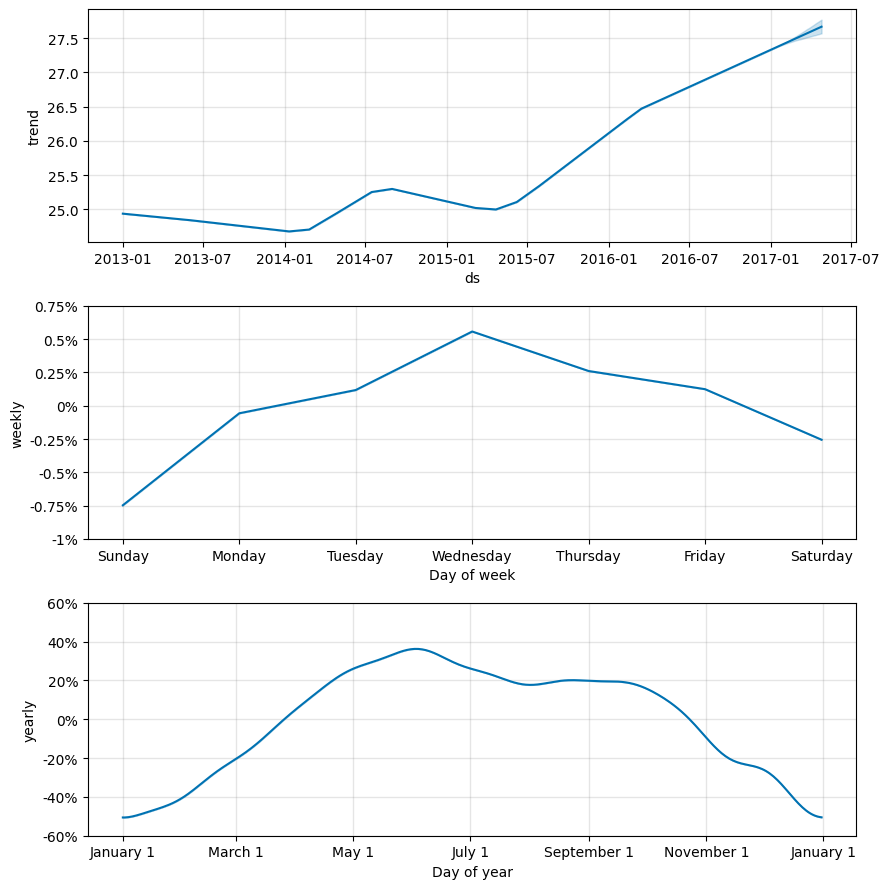

In [ ]:
fig1 = model.plot_components(forecast)
plt.tight_layout()
plt.show()

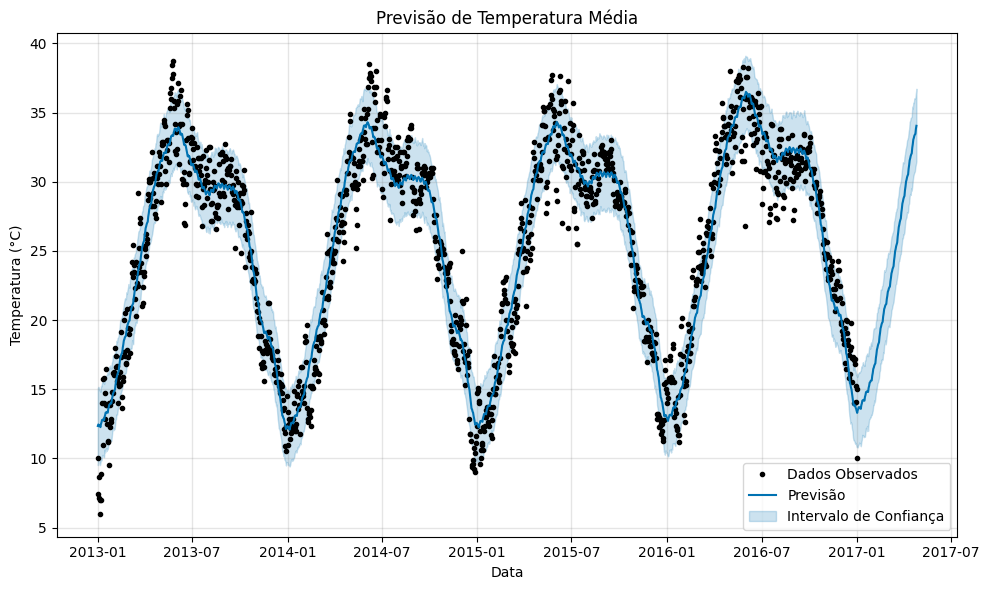

In [ ]:
fig2 = model.plot(forecast)
plt.title('Previsão de Temperatura Média')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend(['Dados Observados', 'Previsão', 'Intervalo de Confiança'])
plt.tight_layout()
plt.show()

In [ ]:
prophet_test = prepare_data_for_prophet(df_test, target_column)
forecast_test = forecast.tail(len(df_test)).copy()

In [ ]:
y_true = prophet_test['y'].values
y_pred = forecast_test['yhat'].values

In [ ]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'Métricas de avaliação para {target_column}:')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')
print(f'MAPE: {mape:.4f}%')

Métricas de avaliação para meantemp:
MAE: 2.1145
RMSE: 2.6150
R²: 0.8295
MAPE: 10.8876%


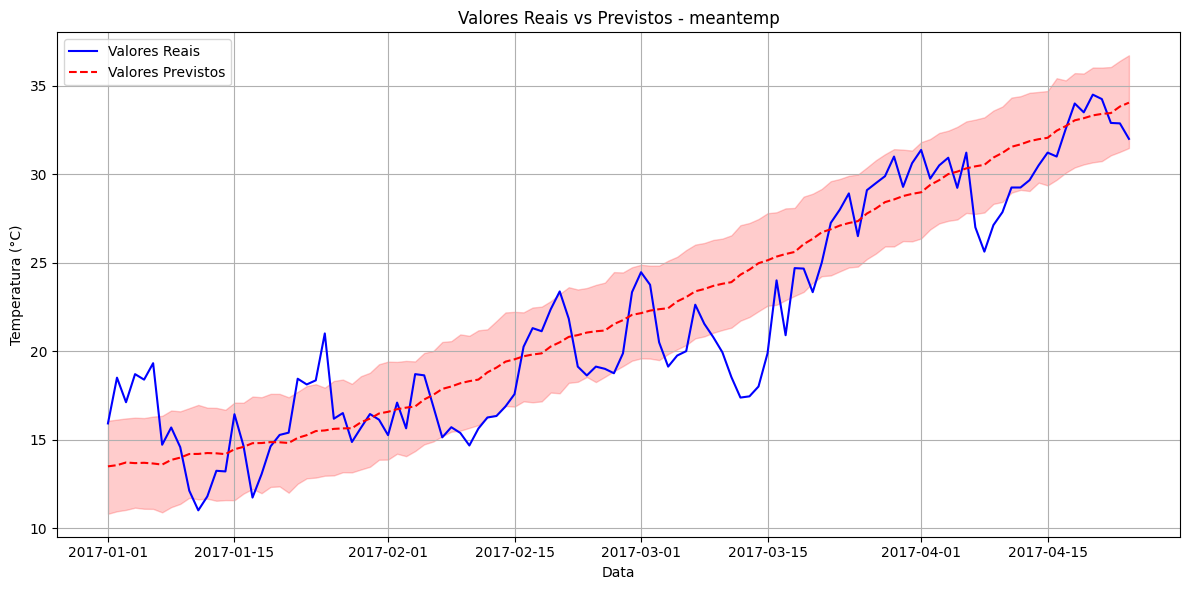

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(prophet_test['ds'], y_true, label='Valores Reais', color='blue')
plt.plot(prophet_test['ds'], y_pred, label='Valores Previstos', color='red', linestyle='--')
plt.fill_between(prophet_test['ds'],
                 forecast_test['yhat_lower'].values,
                 forecast_test['yhat_upper'].values,
                 color='red', alpha=0.2)
plt.title(f'Valores Reais vs Previstos - {target_column}')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [ ]:
def prepare_data_lstm(df_train, df_test, target_col, seq_length=30):

    train_data = df_train[target_col].values.reshape(-1, 1)
    test_data = df_test[target_col].values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    X_train, y_train = create_sequences(train_scaled, seq_length)

    X_test, y_test = create_sequences(test_scaled, seq_length)

    return X_train, y_train, X_test, y_test, scaler

In [ ]:
target_col = 'meantemp'
seq_length = 30

X_train, y_train, X_test, y_test, scaler = prepare_data_lstm(df_train, df_test, target_col, seq_length)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1432, 30, 1)
y_train shape: (1432, 1)
X_test shape: (84, 30, 1)
y_test shape: (84, 1)


In [ ]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.1013 - val_loss: 0.0074
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0078 - val_loss: 0.0046
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0063 - val_loss: 0.0041
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0055 - val_loss: 0.0040
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0056 - val_loss: 0.0039
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0049 - val_loss: 0.0041
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/ste

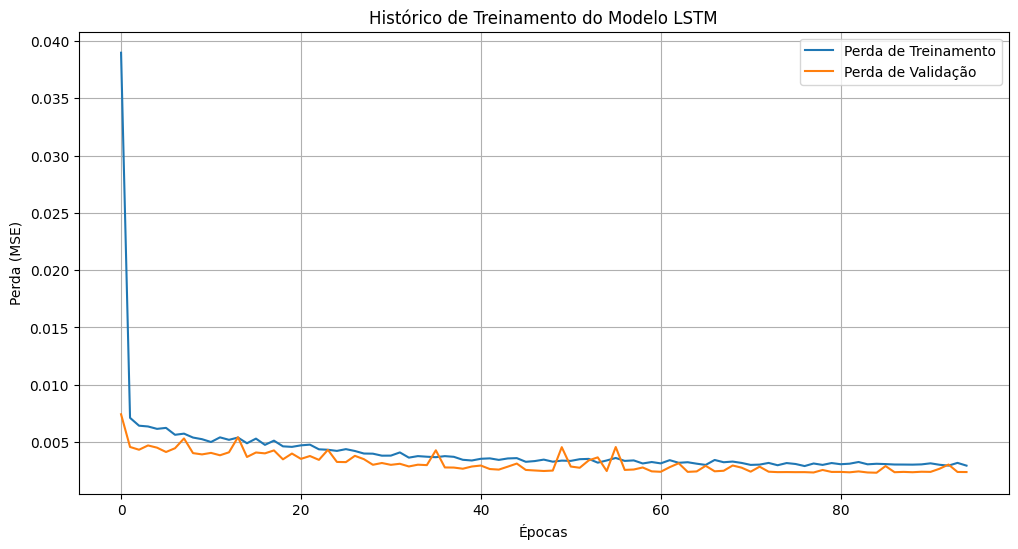

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Histórico de Treinamento do Modelo LSTM')
plt.xlabel('Épocas')
plt.ylabel('Perda (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


In [ ]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f'Métricas de avaliação para {target_col} usando LSTM:')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')
print(f'MAPE: {mape:.4f}%')

Métricas de avaliação para meantemp usando LSTM:
MAE: 1.3554
RMSE: 1.6792
R²: 0.9188
MAPE: 5.8816%


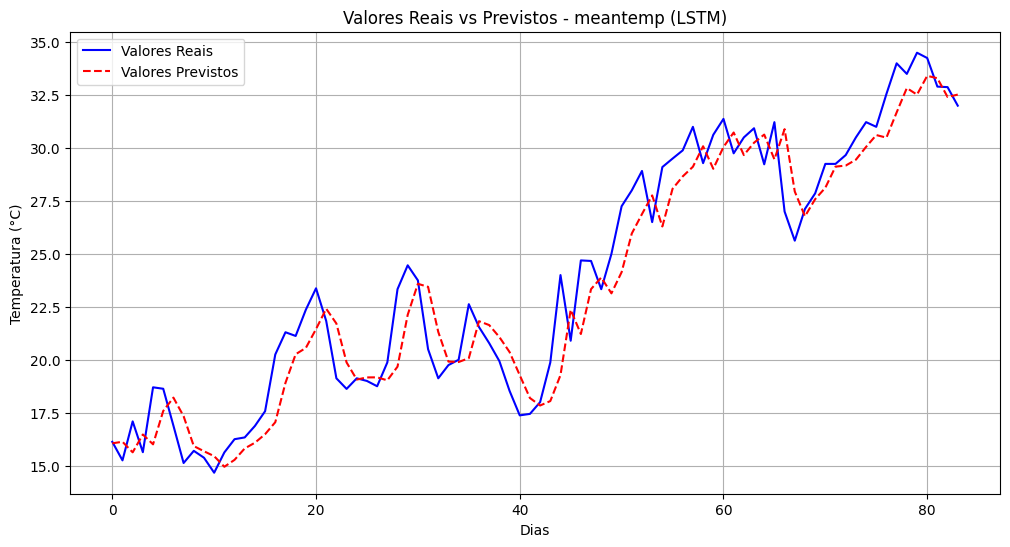

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Valores Reais', color='blue')
plt.plot(y_pred_inv, label='Valores Previstos', color='red', linestyle='--')
plt.title(f'Valores Reais vs Previstos - {target_col} (LSTM)')
plt.xlabel('Dias')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def train_evaluate_lstm(df_train, df_test, target_col, seq_length=30, epochs=100):
    X_train, y_train, X_test, y_test, scaler = prepare_data_lstm(df_train, df_test, target_col, seq_length)

    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )

    y_pred = model.predict(X_test)

    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_inv = scaler.inverse_transform(y_pred)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    r2 = r2_score(y_test_inv, y_pred_inv)

    try:
        mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
    except:
        mape = np.inf

    return {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE': mape
    }

In [ ]:
meteorological_vars = ['humidity', 'wind_speed', 'meanpressure']
lstm_results = {}

lstm_results['meantemp'] = {
    'MAE': mae,
    'RMSE': rmse,
    'R²': r2,
    'MAPE': mape
}

for var in meteorological_vars:
    print(f"\nTreinando modelo LSTM para {var}...")
    results = train_evaluate_lstm(df_train, df_test, var)
    lstm_results[var] = results

    print(f'MAE: {results["MAE"]:.4f}')
    print(f'RMSE: {results["RMSE"]:.4f}')
    print(f'R²: {results["R²"]:.4f}')
    print(f'MAPE: {results["MAPE"]:.4f}%')


Treinando modelo LSTM para humidity...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step
MAE: 5.6858
RMSE: 6.8944
R²: 0.8170
MAPE: 13.8077%

Treinando modelo LSTM para wind_speed...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
MAE: 2.5292
RMSE: 3.2514
R²: 0.1987
MAPE: 45.3294%

Treinando modelo LSTM para meanpressure...
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
MAE: 4.3361
RMSE: 5.3022
R²: -0.0143
MAPE: 0.4302%


In [ ]:
prophet_results = {}

prophet_results['meantemp'] = {
    'MAE': mae,
    'RMSE': rmse,
    'R²': r2,
    'MAPE': mape
}

meteorological_vars = ['humidity', 'wind_speed', 'meanpressure']

for var in meteorological_vars:
    prophet_train_var = prepare_data_for_prophet(df_train, var)

    model_var = Prophet(yearly_seasonality=True,
                        weekly_seasonality=True,
                        seasonality_mode='multiplicative')

    model_var.fit(prophet_train_var)
    future_var = model_var.make_future_dataframe(periods=len(df_test), freq='D')
    forecast_var = model_var.predict(future_var)

    prophet_test_var = prepare_data_for_prophet(df_test, var)
    forecast_test_var = forecast_var.tail(len(df_test)).copy()

    y_true_var = prophet_test_var['y'].values
    y_pred_var = forecast_test_var['yhat'].values

    mae_var = mean_absolute_error(y_true_var, y_pred_var)
    rmse_var = np.sqrt(mean_squared_error(y_true_var, y_pred_var))
    r2_var = r2_score(y_true_var, y_pred_var)

    if np.any(y_true_var == 0):
        mape_var = np.inf
    else:
        mape_var = np.mean(np.abs((y_true_var - y_pred_var) / y_true_var)) * 100

    prophet_results[var] = {
        'MAE': mae_var,
        'RMSE': rmse_var,
        'R²': r2_var,
        'MAPE': mape_var
    }

prophet_df = pd.DataFrame(prophet_results).T
lstm_df = pd.DataFrame(lstm_results).T

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyncln8kc/dc_uvqkq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyncln8kc/no3wpc5h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28208', 'data', 'file=/tmp/tmpyncln8kc/dc_uvqkq.json', 'init=/tmp/tmpyncln8kc/no3wpc5h.json', 'output', 'file=/tmp/tmpyncln8kc/prophet_modelqanmrhsm/prophet_model-20250326120004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:00:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:00:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpyn

In [ ]:
prophet_df

,MAE,RMSE,R²,MAPE
meantemp,1.355410,1.679171,0.918798,5.881604
humidity,8.396023,10.462730,0.696260,19.924991
wind_speed,2.830356,3.551358,0.011678,51.372642
meanpressure,37.239307,97.117575,-0.188561,17.291354


In [ ]:
lstm_df

,MAE,RMSE,R²,MAPE
meantemp,1.355410,1.679171,0.918798,5.881604
humidity,5.685765,6.894357,0.817010,13.807739
wind_speed,2.529181,3.251443,0.198650,45.329403
meanpressure,4.336142,5.302181,-0.014299,0.430245


In [ ]:
diff_df = pd.DataFrame(index=lstm_df.index, columns=lstm_df.columns)

for var in lstm_df.index:
    for metric in lstm_df.columns:
        if metric == 'R²':
            diff_df.loc[var, metric] = (lstm_df.loc[var, metric] - prophet_df.loc[var, metric])
        else:
            diff_df.loc[var, metric] = (prophet_df.loc[var, metric] - lstm_df.loc[var, metric])

print("\nDiferença (valores positivos indicam que LSTM é melhor, negativos que Prophet é melhor):")
diff_df


Diferença (valores positivos indicam que LSTM é melhor, negativos que Prophet é melhor):


,MAE,RMSE,R²,MAPE
meantemp,0.0,0.0,0.0,0.0
humidity,2.710258,3.568373,0.12075,6.117252
wind_speed,0.301175,0.299915,0.186972,6.04324
meanpressure,32.903165,91.815394,0.174262,16.861109


In [ ]:
def get_best_model(prophet_val, lstm_val, metric):
    if metric == 'R²':
        return 'LSTM' if lstm_val > prophet_val else 'Prophet'
    else:
        return 'LSTM' if lstm_val < prophet_val else 'Prophet'

best_model_df = pd.DataFrame(index=lstm_df.index, columns=lstm_df.columns)

for var in lstm_df.index:
    for metric in lstm_df.columns:
        best_model_df.loc[var, metric] = get_best_model(
            prophet_df.loc[var, metric],
            lstm_df.loc[var, metric],
            metric
        )

print("\nMelhor modelo por variável e métrica:")
best_model_df


Melhor modelo por variável e métrica:


,MAE,RMSE,R²,MAPE
meantemp,Prophet,Prophet,Prophet,Prophet
humidity,LSTM,LSTM,LSTM,LSTM
wind_speed,LSTM,LSTM,LSTM,LSTM
meanpressure,LSTM,LSTM,LSTM,LSTM
